# imports 

In [335]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi, enums
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline import shared
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH_DNET = Path('/home/Deep_Learner/private/datasets/DNETs/')
PATH_DNET_WSIS = PATH_DNET/'wsis'
PATH_GANGLIOGLIOMA = Path('/home/Deep_Learner/private/datasets/Ganglioglioma/')


seed = 42
np.random.seed(seed)

# data

## wsi and json paths

In [390]:
wsi_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET_WSIS, extensions=['.ndpi'])
wsi_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.ndpi'])
wsi_paths = list(wsi_paths_dnets+wsi_paths_ganglioglioma)

json_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET, extensions=['.json'])
json_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.json'])
json_paths = list(json_paths_dnets+json_paths_ganglioglioma)

In [315]:
print(len(wsi_paths_dnets))
print(len(json_paths_dnets))
print(len(wsi_paths_ganglioglioma))
print(len(json_paths_ganglioglioma))

55
49
176
167


## wsi path to json file mapping and roi creation

In [396]:
def get_json_path_for_wsi(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    wsi_name = wsi_path.stem
    for jp in json_paths:
        if(wsi_name == jp.stem):
            return jp
    
    raise FileNotFoundError(f'json file could not be found for {wsi_path}')

        
def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = get_json_path_for_wsi(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

In [399]:
wsi_paths_all_without_corresponding_json_file = []
wsi_path_to_json_path = {}

for wp in wsi_paths:
    try:
        json_path = get_json_path_for_wsi(wsi_path=wp, json_paths=json_paths)
        wsi_path_to_json_path[wp] = json_path
        
        #if(json_path in duplicates):
        #if(json_path in jps):
        #    print(wp)
        #jps.append(json_path)
    except FileNotFoundError:
        wsi_paths_all_without_corresponding_json_file.append(wp)

In [400]:
wsi_paths_all_without_corresponding_json_file

[Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1365-13-I2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1825-18-I13.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1684 18-I8.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1684 18-IV2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1825-18-I7.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNETs/wsis/N1684 18-IV1.ndpi'),
 Path('/home/Deep_Learner/private/datasets/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N164-19-5.ndpi'),
 Path('/home/Deep_Learner/private/datasets/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N402-16.ndpi'),
 Path('/home/Deep_Learner/private/datasets/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N829-17-IV2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II3.1.ndpi'),
 Path('/home/Deep_Learner/private/datasets/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-

In [401]:
wsi_paths_with_json_files = list(wsi_path_to_json_path.keys())

In [402]:
wsi_path_to_rois = {}
for wp in wsi_paths_with_json_files:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

## id and label funcs

In [403]:
# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    if('casus' in str(wsi_path.stem)):
        return wsi_path.stem
    split = wsi_path.stem.split('-')
    return f'{split[0]}-{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    if('Ganglioglioma' in str(wsi_path)):
        return ['Ganglioglioma']
    if('DNETs' in str(wsi_path)):
        return ['DNET']
    raise AssertionError(f'No label could be determinated for {wsi_path}')

## tiles

In [325]:
tilesummaries = tiles.WsisToTilesParallel(wsi_paths=wsi_path_to_json_path.keys(), 
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          minimal_acceptable_tile_height=0.7, 
                                          minimal_acceptable_tile_width=0.7,
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois ,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False)







  0%|          | 0/216 [00:00<?, ?it/s]





  0%|          | 1/216 [00:13<49:52, 13.92s/it]





  1%|          | 2/216 [00:14<35:35,  9.98s/it]





  1%|▏         | 3/216 [00:16<26:27,  7.45s/it]





  2%|▏         | 5/216 [00:16<18:24,  5.23s/it]





  3%|▎         | 7/216 [00:16<12:49,  3.68s/it]





  4%|▎         | 8/216 [00:17<09:58,  2.88s/it]





  4%|▍         | 9/216 [00:18<07:58,  2.31s/it]





  5%|▍         | 10/216 [00:19<06:44,  1.97s/it]





  6%|▌         | 13/216 [00:19<04:42,  1.39s/it]





  6%|▋         | 14/216 [00:20<03:43,  1.11s/it]





  7%|▋         | 16/216 [00:20<02:40,  1.24it/s]





  8%|▊         | 17/216 [00:21<02:54,  1.14it/s]





  8%|▊         | 18/216 [00:21<02:15,  1.46it/s]





  9%|▉         | 20/216 [00:22<01:46,  1.85it/s]





 10%|▉         | 21/216 [00:22<01:56,  1.68it/s]





 10%|█         | 22/216 [00:26<04:30,  1.40s/it]





 12%|█▎        | 27/216 [00:26<03:14,  1.03s/it]





 13%|█▎        | 28/216 [00:27<02:52, 

Can't validate JPEG for directory 0: Expected marker at 4294972560, found none








 14%|█▍        | 31/216 [00:28<01:28,  2.08it/s]

Can't validate JPEG for directory 0: Expected marker at 4294974338, found none








 15%|█▍        | 32/216 [00:28<01:24,  2.17it/s]





 15%|█▌        | 33/216 [00:28<01:11,  2.56it/s]





 16%|█▌        | 34/216 [00:29<01:07,  2.71it/s]





 16%|█▌        | 35/216 [00:31<02:26,  1.24it/s]





 17%|█▋        | 36/216 [00:31<01:47,  1.67it/s]





 17%|█▋        | 37/216 [00:31<01:33,  1.92it/s]





 18%|█▊        | 39/216 [00:32<01:18,  2.26it/s]





 19%|█▉        | 41/216 [00:33<01:20,  2.18it/s]





 19%|█▉        | 42/216 [00:33<01:04,  2.70it/s]





 20%|█▉        | 43/216 [00:33<00:54,  3.18it/s]





 21%|██        | 45/216 [00:33<00:49,  3.44it/s]





 21%|██▏       | 46/216 [00:34<00:58,  2.91it/s]





 22%|██▏       | 47/216 [00:34<00:49,  3.45it/s]





 22%|██▏       | 48/216 [00:36<01:54,  1.47it/s]





 23%|██▎       | 50/216 [00:37<01:44,  1.58it/s]





 24%|██▍       | 52/216 [00:37<01:20,  2.03it/s]





 25%|██▌       | 54/216 [00:38<01:10,  2.30it/s]





 25%|██▌       | 55/216 [00:38<01:11,  2.25it/s]





 26%|██▌       | 56/21

Can't validate JPEG for directory 0: Expected marker at 4294970859, found none
Can't validate JPEG for directory 0: Expected marker at 4294970978, found none








 29%|██▉       | 63/216 [00:43<01:37,  1.58it/s]





 30%|██▉       | 64/216 [00:43<01:24,  1.79it/s]





 30%|███       | 65/216 [00:44<01:10,  2.14it/s]





 31%|███       | 66/216 [00:44<01:04,  2.34it/s]

Can't validate JPEG for directory 0: Expected marker at 4294970979, found none








 31%|███       | 67/216 [00:46<02:20,  1.06it/s]





 31%|███▏      | 68/216 [00:47<02:08,  1.15it/s]





 32%|███▏      | 69/216 [00:47<01:46,  1.38it/s]





 32%|███▏      | 70/216 [00:47<01:30,  1.62it/s]





 33%|███▎      | 71/216 [00:48<01:10,  2.05it/s]





 33%|███▎      | 72/216 [00:48<01:08,  2.09it/s]





 34%|███▍      | 73/216 [00:48<00:52,  2.74it/s]





 34%|███▍      | 74/216 [00:48<00:42,  3.33it/s]





 35%|███▍      | 75/216 [00:49<00:36,  3.84it/s]





 35%|███▌      | 76/216 [00:49<00:47,  2.97it/s]





 36%|███▌      | 77/216 [00:49<00:43,  3.21it/s]





 36%|███▌      | 78/216 [00:50<00:42,  3.28it/s]





 37%|███▋      | 79/216 [00:50<00:42,  3.21it/s]





 37%|███▋      | 80/216 [00:51<00:53,  2.52it/s]





 38%|███▊      | 81/216 [00:51<01:10,  1.91it/s]





 38%|███▊      | 82/216 [00:51<00:53,  2.49it/s]





 38%|███▊      | 83/216 [00:52<00:42,  3.10it/s]





 39%|███▉      | 84/216 [00:52<00:53,  2.48it/s]





 39%|███▉      | 85/21

Can't validate JPEG for directory 0: Expected marker at 4294970798, found none
Can't validate JPEG for directory 0: Expected marker at 4294970918, found none
Can't validate JPEG for directory 0: Expected marker at 4294970878, found none








 46%|████▋     | 100/216 [00:57<00:35,  3.29it/s]

Can't validate JPEG for directory 0: Expected marker at 4294976126, found none








 47%|████▋     | 101/216 [00:58<00:42,  2.73it/s]





 47%|████▋     | 102/216 [00:58<00:38,  2.95it/s]

Can't validate JPEG for directory 0: Expected marker at 4294973902, found none








 48%|████▊     | 103/216 [00:58<00:33,  3.35it/s]





 48%|████▊     | 104/216 [00:59<00:41,  2.70it/s]





 49%|████▊     | 105/216 [00:59<00:48,  2.27it/s]





 49%|████▉     | 106/216 [01:00<00:50,  2.20it/s]





 50%|████▉     | 107/216 [01:00<00:49,  2.20it/s]





 50%|█████     | 108/216 [01:01<00:44,  2.42it/s]





 50%|█████     | 109/216 [01:01<00:38,  2.78it/s]





 51%|█████     | 110/216 [01:01<00:33,  3.14it/s]





 51%|█████▏    | 111/216 [01:02<00:41,  2.55it/s]





 52%|█████▏    | 112/216 [01:02<00:36,  2.84it/s]





 52%|█████▏    | 113/216 [01:02<00:36,  2.83it/s]TopologyException: Input geom 0 is invalid: Self-intersection at or near point 89612.963333591149 37976.510000000002 at 89612.963333591149 37976.510000000002


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f4882c5ea90>








 53%|█████▎    | 114/216 [01:03<00:47,  2.14it/s]





 53%|█████▎    | 115/216 [01:03<00:41,  2.44it/s]





 54%|█████▎    | 116/216 [01:03<00:32,  3.10it/s]





 54%|█████▍    | 117/216 [01:04<00:32,  3.05it/s]





 55%|█████▍    | 118/216 [01:04<00:28,  3.43it/s]





 55%|█████▌    | 119/216 [01:05<01:04,  1.49it/s]





 56%|█████▌    | 120/216 [01:06<00:56,  1.71it/s]





 56%|█████▌    | 121/216 [01:06<00:47,  2.00it/s]





 56%|█████▋    | 122/216 [01:06<00:36,  2.58it/s]





 57%|█████▋    | 123/216 [01:07<00:42,  2.19it/s]





 57%|█████▋    | 124/216 [01:08<00:47,  1.93it/s]





 58%|█████▊    | 126/216 [01:08<00:34,  2.62it/s]





 59%|█████▉    | 127/216 [01:08<00:35,  2.47it/s]





 59%|█████▉    | 128/216 [01:09<00:35,  2.45it/s]





 60%|██████    | 130/216 [01:09<00:27,  3.08it/s]





 61%|██████    | 131/216 [01:09<00:24,  3.46it/s]





 62%|██████▏   | 133/216 [01:11<00:36,  2.26it/s]





 62%|██████▎   | 135/216 [01:11<00:26,  3.07it/s]





 63%

Can't validate JPEG for directory 0: Expected marker at 4294971043, found none
Can't validate JPEG for directory 0: Expected marker at 4294974266, found none
Can't validate JPEG for directory 0: Expected marker at 4294970639, found none
Can't validate JPEG for directory 0: Expected marker at 4294976170, found none








 68%|██████▊   | 146/216 [01:18<00:36,  1.91it/s]





 69%|██████▊   | 148/216 [01:18<00:26,  2.57it/s]





 69%|██████▉   | 149/216 [01:20<00:58,  1.15it/s]





 70%|██████▉   | 151/216 [01:20<00:40,  1.59it/s]





 70%|███████   | 152/216 [01:20<00:36,  1.76it/s]





 71%|███████   | 153/216 [01:21<00:31,  2.02it/s]





 71%|███████▏  | 154/216 [01:21<00:25,  2.48it/s]





 72%|███████▏  | 156/216 [01:21<00:18,  3.27it/s]





 73%|███████▎  | 157/216 [01:21<00:16,  3.59it/s]





 73%|███████▎  | 158/216 [01:21<00:13,  4.23it/s]





 74%|███████▎  | 159/216 [01:22<00:12,  4.57it/s]





 74%|███████▍  | 160/216 [01:22<00:17,  3.22it/s]





 75%|███████▍  | 161/216 [01:22<00:14,  3.88it/s]





 75%|███████▌  | 162/216 [01:23<00:18,  2.95it/s]





 75%|███████▌  | 163/216 [01:24<00:23,  2.21it/s]





 76%|███████▋  | 165/216 [01:25<00:23,  2.15it/s]





 77%|███████▋  | 166/216 [01:25<00:26,  1.85it/s]





 77%|███████▋  | 167/216 [01:25<00:20,  2.45it/s]





 78%

In [352]:
roi_ids = []
for ts in tilesummaries:
    for r in ts.rois:
        roi_ids.append(r.roi_id)

In [337]:
print(len(roi_ids))

779


In [338]:
print(len(set(roi_ids)))

775


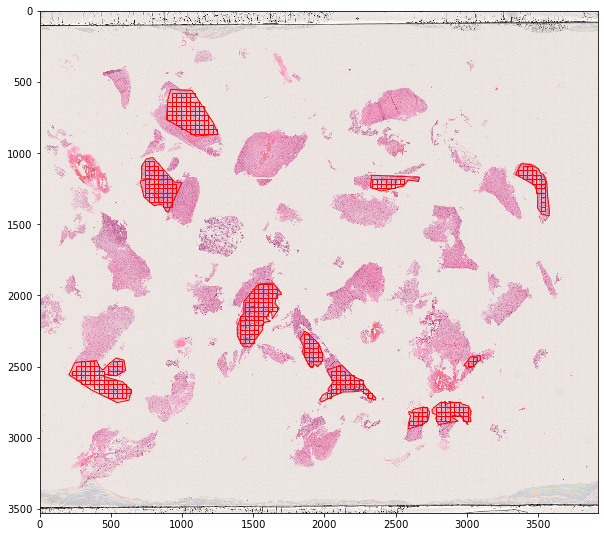

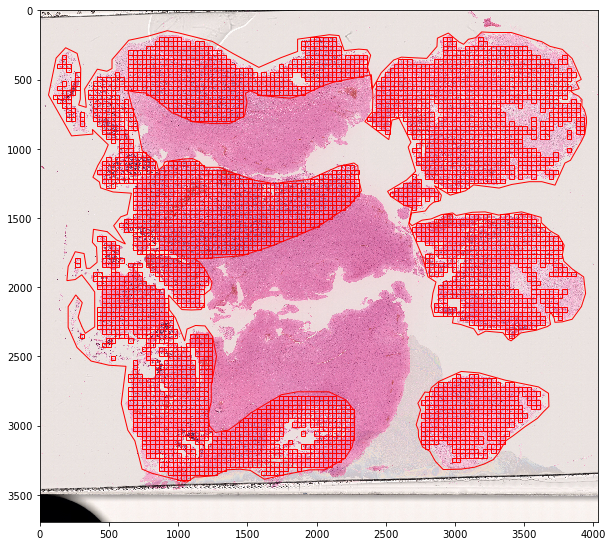

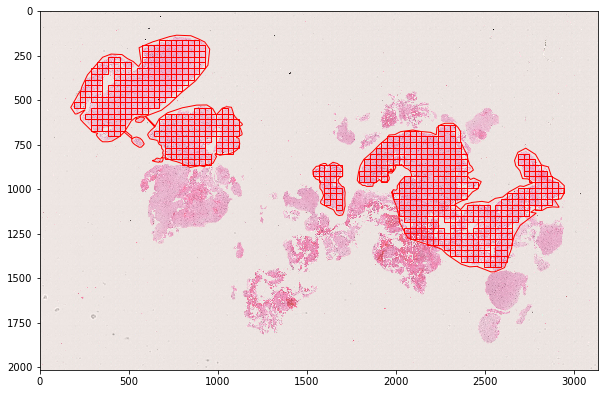

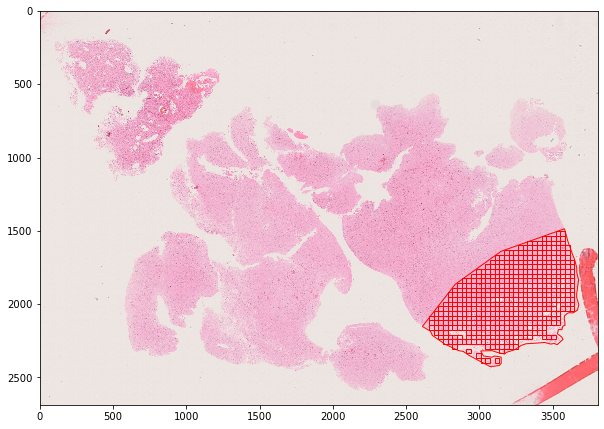

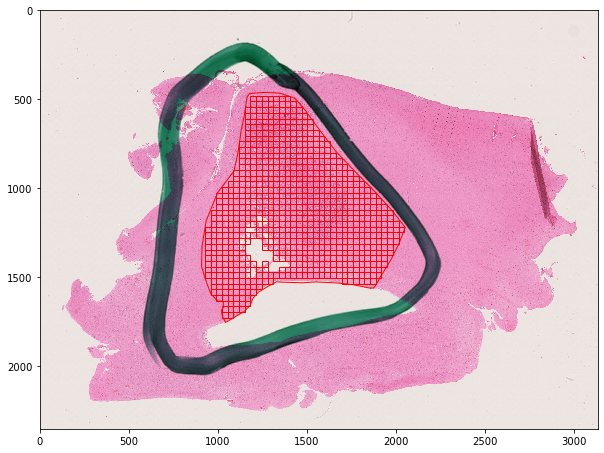

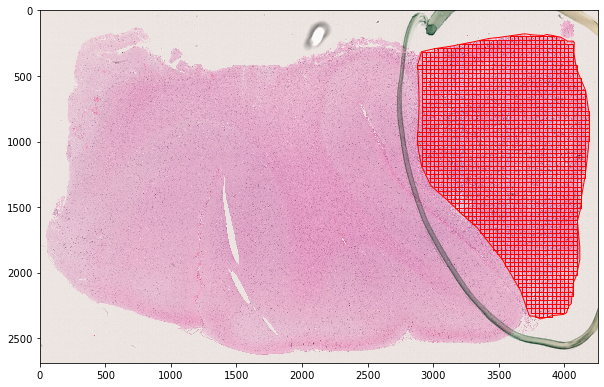

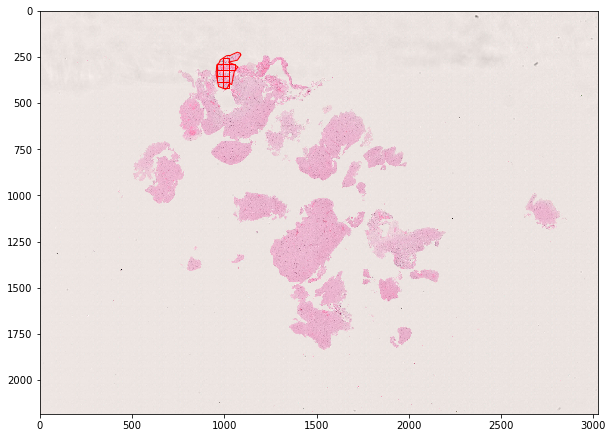

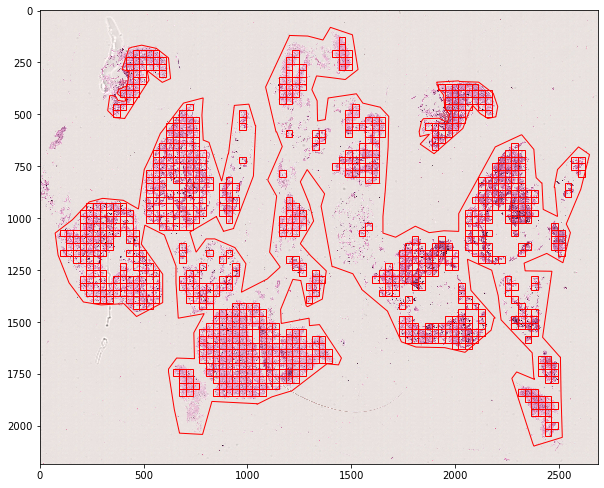

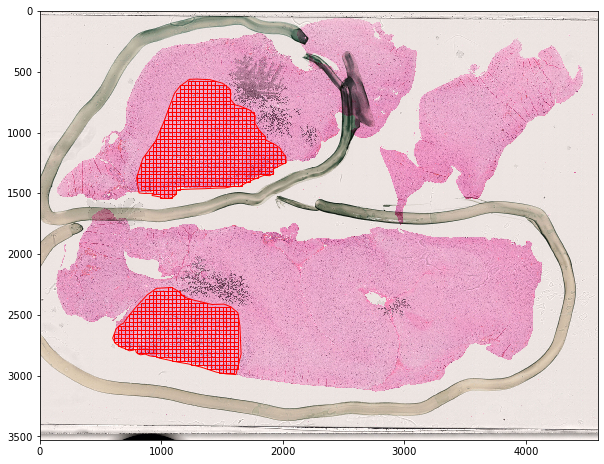

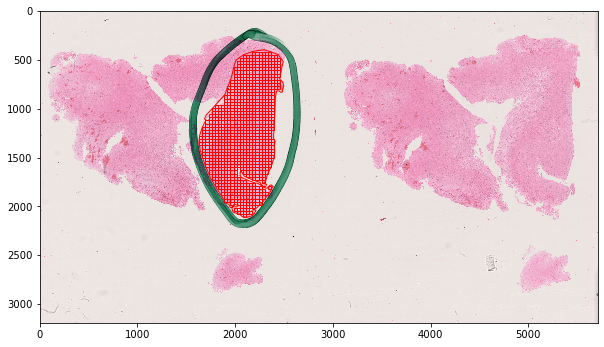

In [236]:
for ts in random.sample(tilesummaries, 10):
    ts.show_wsi_with_top_tiles()

## patient manager 

In [252]:
patient_manager = PatientManager()

In [253]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)






  0%|          | 0/202 [00:00<?, ?it/s]




 14%|█▍        | 29/202 [00:00<00:00, 277.41it/s]




 21%|██        | 42/202 [00:00<00:00, 194.59it/s]




 31%|███       | 63/202 [00:00<00:00, 189.97it/s]




 38%|███▊      | 77/202 [00:00<00:00, 165.62it/s]




 45%|████▌     | 91/202 [00:00<00:00, 151.66it/s]




 51%|█████▏    | 104/202 [00:00<00:00, 123.46it/s]




 57%|█████▋    | 116/202 [00:00<00:00, 107.34it/s]




 65%|██████▌   | 132/202 [00:00<00:00, 118.13it/s]




 71%|███████▏  | 144/202 [00:01<00:00, 109.10it/s]




 77%|███████▋  | 156/202 [00:01<00:00, 110.28it/s]




 84%|████████▍ | 170/202 [00:01<00:00, 115.23it/s]




 93%|█████████▎| 187/202 [00:01<00:00, 126.75it/s]




100%|██████████| 202/202 [00:01<00:00, 112.90it/s]

779
775


ValueError: The rois do not have unique ids.

In [254]:
roi_ids = []
for rs in wsi_path_to_rois.values():
    for r in rs:
        roi_ids.append(r.roi_id)

In [255]:
print(len(roi_ids))

797


In [256]:
print(len(set(roi_ids)))

793


In [257]:
import collections
print([item for item, count in collections.Counter(roi_ids).items() if count > 1])

['N548-07-II7_roi_number_0', 'N881-06-I1_roi_number_0', 'N881-06-I1_roi_number_1', 'N881-06-I1_roi_number_2']
